In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)
degree = 1
zero_coeff = 0.1
scale_fft = 1
coeffs = [0.15 + 0.15j]*degree

def tgt(x):
    res = zero_coeff
    for id, coeff in enumerate(coeffs):
        exponent = np.complex128(scale_fft * (id+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)
def loss(t, p):
    loss = 0
    for i, j in zip(t, p):
        loss += (i - j) ** 2
    loss = loss / len(t)
    return 0.5*loss

In [2]:
x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([tgt(j) for j in x], requires_grad=False)

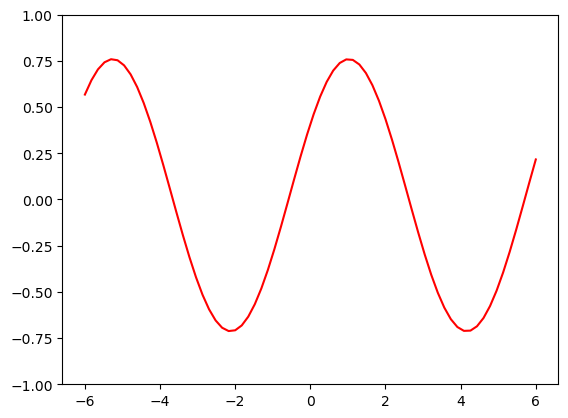

In [3]:
scale_fft = 1

dev = qml.device('default.qubit', wires=1)

def S(x):
    qml.RX(scale_fft * x, wires=0)

def W(ang):
    qml.Rot(ang[0],ang[1],ang[2], wires=0)

@qml.qnode(dev)
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

r = 1 
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) 

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='red')
plt.ylim(-1,1)
plt.show()

In [4]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(2.35,5.97,4.60)──RX(6.00)──Rot(3.76,0.98,0.98)─┤  <Z>


In [5]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return loss(y, predictions)
opt = qml.AdamOptimizer(0.3)
size_b = 25
max_steps = 50
cst = [cost(weights, x, target_y)]

for step in range(max_steps):
    index_b = np.random.randint(0, len(x), (size_b,))
    x_1 = x[index_b]
    y_1 = target_y[index_b]
    weights, _, _ = opt.step(cost, weights, x_1, y_1)
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.03212041720004566
Cost at step  20: 0.013853561883024668
Cost at step  30: 0.004049396436389457
Cost at step  40: 0.0005624933894468403
Cost at step  50: 8.145777333271021e-05


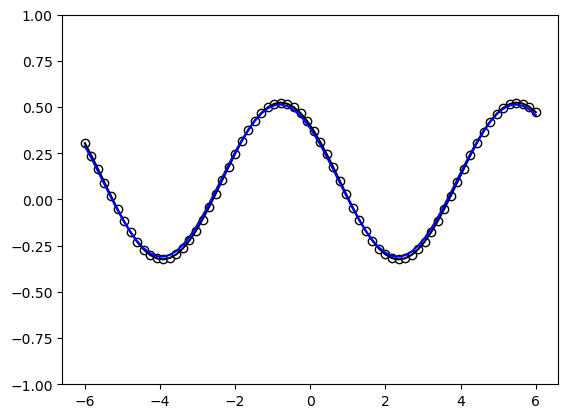

In [6]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

In [7]:
from pennylane.templates import StronglyEntanglingLayers

In [8]:
n_ansatz_layers = 2
n_qubits = 3

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, expansion_strategy="device")(weights_ansatz))
scale_fft = 1
r = 3

dev = qml.device('default.qubit', wires=r)


def W(angle):
    StronglyEntanglingLayers(angle, wires=range(r))

def S(factor):
    for w in range(r):
        qml.RX(scale_fft * factor, wires=w)

@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

0: ──Rot(1.38,4.29,0.48)─╭●────╭X──Rot(4.26,3.55,1.68)─╭●─╭X────┤  <I>
1: ──Rot(5.35,3.11,3.02)─╰X─╭●─│───Rot(5.52,5.01,4.14)─│──╰●─╭X─┤     
2: ──Rot(3.72,5.18,2.19)────╰X─╰●──Rot(5.34,5.45,4.45)─╰X────╰●─┤     


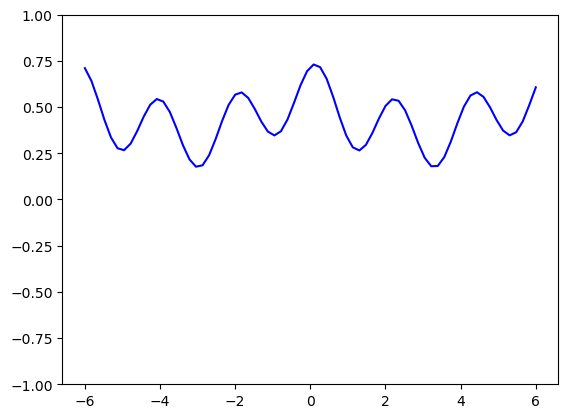

In [9]:
tbl = 3
weights = 2 * np.pi * np.random.random(size=(2, tbl, r, 3), requires_grad=True)

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

In [10]:
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x_) for x_ in x]
    return loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
size_b = 25
cst = [cost(weights, x, target_y)]

for step in range(max_steps):
    index_b = np.random.randint(0, len(x), (size_b,))
    x_1 = x[index_b]
    y_1 = target_y[index_b]
    weights, _, _ = opt.step(cost, weights, x_1, y_1)
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.017166449445319372
Cost at step  20: 0.005497199314425552
Cost at step  30: 0.004784402394898692
Cost at step  40: 0.004015481434555598
Cost at step  50: 0.0013998102989784796


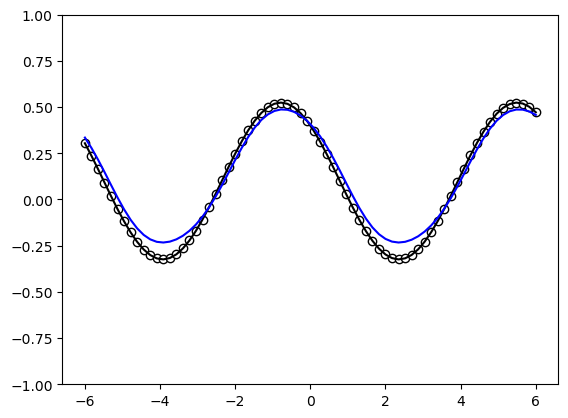

In [11]:
predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

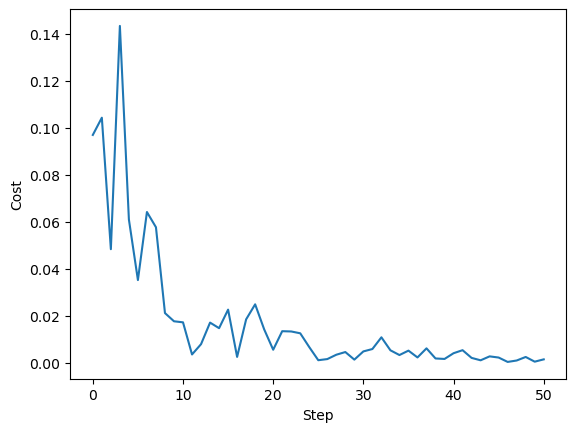

In [12]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show();


In [13]:
def fourier_coefficients(f, K):
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y


In [14]:
from pennylane.templates import BasicEntanglerLayers

scale_fft = 1
n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

def S(x):
    for w in range(n_qubits):
        qml.RX(scale_fft * x, wires=w)

def W(theta):
    BasicEntanglerLayers(theta, wires=range(n_qubits))


@qml.qnode(dev)
def quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

In [15]:
n_ansatz_layers = 1

def random_weights():
    return 2 * np.pi * np.random.random(size=(2, n_ansatz_layers, n_qubits))

In [16]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

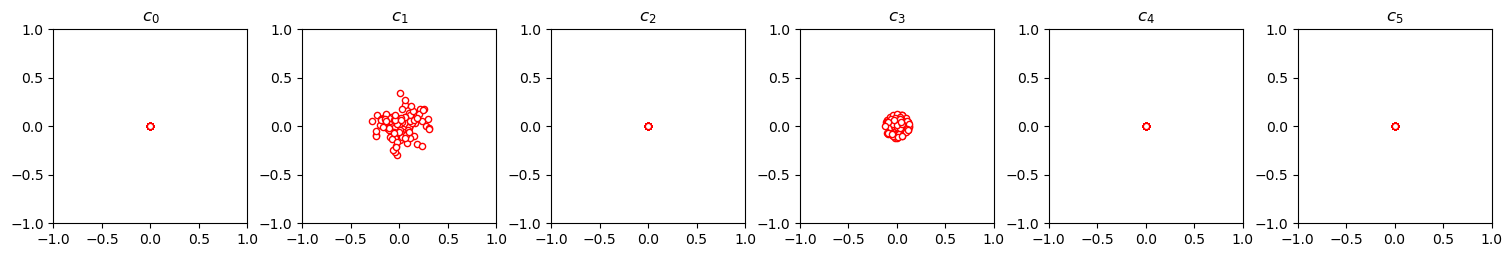

In [17]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15, 4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=20,
                facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show();